In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.preprocessing import MultiLabelBinarizer
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from multiprocessing import Pool
import soundfile as sf
from tqdm import tqdm

import os

In [2]:
DEV_ROOT = 'D:/Downloads/FSD50K.dev_audio/'
TEST_ROOT = './Data/FSD50K.eval_audio/'

raw_dev_df = pd.read_csv("C:/Users/Harry/Desktop/FSD50K.ground_truth/FSD50K.ground_truth/dev.csv", dtype={'fname': 'string'})

train_df = raw_dev_df[raw_dev_df['split'] == 'train'].drop(columns=['split']).copy()
val_df = raw_dev_df[raw_dev_df['split'] == 'val'].drop(columns=['split']).copy()
test_df = pd.read_csv("C:/Users/Harry/Desktop/FSD50K.ground_truth/FSD50K.ground_truth/eval.csv", dtype={'fname': 'string'})
vocab_df = pd.read_csv('C:/Users/Harry/Desktop/FSD50K.ground_truth/FSD50K.ground_truth/vocabulary.csv', index_col=0, header=None, names=['label','mids'])
vocab_dict = dict(zip(vocab_df.mids, vocab_df.label))

In [3]:
train_df.head()


,fname,labels,mids
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"


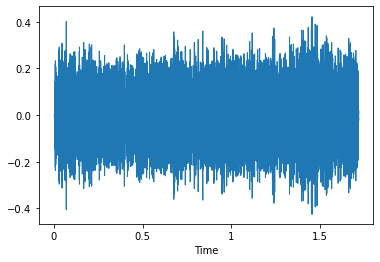

In [4]:
sample_file = DEV_ROOT + train_df.fname[0] + '.wav'
data, sample_rate = librosa.load(sample_file, sr = None)
librosa.display.waveshow(data,sr = sample_rate)
ipd.Audio(sample_file)

In [5]:
print(f'Sample rate: {sample_rate}')
print(f'Audio Length: {len(data)/sample_rate}s')

Sample rate: 44100
Audio Length: 1.7143083900226757s


In [6]:
def audio_adder(filename):
    audio_file = DEV_ROOT + filename + '.wav'
    data, sample_rate = librosa.load(audio_file, sr = None)
    return(len(data)/sample_rate)

In [7]:
def label_onehot_processor(df):
    '''
    Onehot encodes mids and removes labels
    '''
    df.drop(columns=['labels'], inplace=True)
    df['mids'] = df['mids'].apply(lambda x: tuple(x.split(',')))
    df = df.join(pd.DataFrame(one_hot_encoder.fit_transform(df.pop('mids')),
                          columns=one_hot_encoder.classes_,
                          index=df.index))
    return df

In [8]:
one_hot_encoder = MultiLabelBinarizer()
train_df['mids'] = train_df['mids'].apply(lambda x: tuple(x.split(',')))
val_df['mids'] = val_df['mids'].apply(lambda x: tuple(x.split(',')))
test_df['mids'] = test_df['mids'].apply(lambda x: tuple(x.split(',')))
one_hot_encoder.fit(train_df['mids'])

MultiLabelBinarizer()

In [9]:
train_label_vector = one_hot_encoder.transform(train_df['mids'])
val_label_vector = one_hot_encoder.transform(val_df['mids'])
test_label_vector = one_hot_encoder.transform(train_df['mids'])
label_mids_classes = one_hot_encoder.classes_
print("train_label_vector shape: " + ' x '.join(str(v) for v in train_label_vector.shape))
print("val_label_vector shape: " + ' x '.join(str(v) for v in val_label_vector.shape))
print("test_label_vector shape: " + ' x '.join(str(v) for v in test_label_vector.shape))
print("Number of Classes: " + str(len(label_mids_classes)))

train_label_vector shape: 36796 x 200
val_label_vector shape: 4170 x 200
test_label_vector shape: 36796 x 200
Number of Classes: 200


In [10]:
train_label_vector


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
label_mids_classes


array(['/m/01280g', '/m/012f08', '/m/0130jx', '/m/013y1f', '/m/014zdl',
       '/m/015lz1', '/m/015p6', '/m/018vs', '/m/0195fx', '/m/0199g',
       '/m/019jd', '/m/01b82r', '/m/01b_21', '/m/01bjv', '/m/01d380',
       '/m/01dwxx', '/m/01h8n0', '/m/01hgjl', '/m/01hnzm', '/m/01hsr_',
       '/m/01j3sz', '/m/01jt3m', '/m/01kcd', '/m/01lsmm', '/m/01m2v',
       '/m/01m4t', '/m/01p970', '/m/01qbl', '/m/01s0vc', '/m/01x3z',
       '/m/01yrx', '/m/020bb7', '/m/0239kh', '/m/023pjk', '/m/0242l',
       '/m/025_jnm', '/m/025rv6n', '/m/026fgl', '/m/026t6', '/m/028ght',
       '/m/02_41', '/m/02_nn', '/m/02bm9n', '/m/02dgv', '/m/02hnl',
       '/m/02jz0l', '/m/02mk9', '/m/02rtxlg', '/m/02sgy', '/m/02x984l',
       '/m/02y_763', '/m/02yds9', '/m/02zsn', '/m/0316dw', '/m/032s66',
       '/m/0342h', '/m/034srq', '/m/0395lw', '/m/039jq', '/m/03cczk',
       '/m/03dnzn', '/m/03kmc9', '/m/03l9g', '/m/03m5k', '/m/03m9d0z',
       '/m/03q5_w', '/m/03qc9zr', '/m/03qjg', '/m/03qtq', '/m/03qtwd',
       '/m/

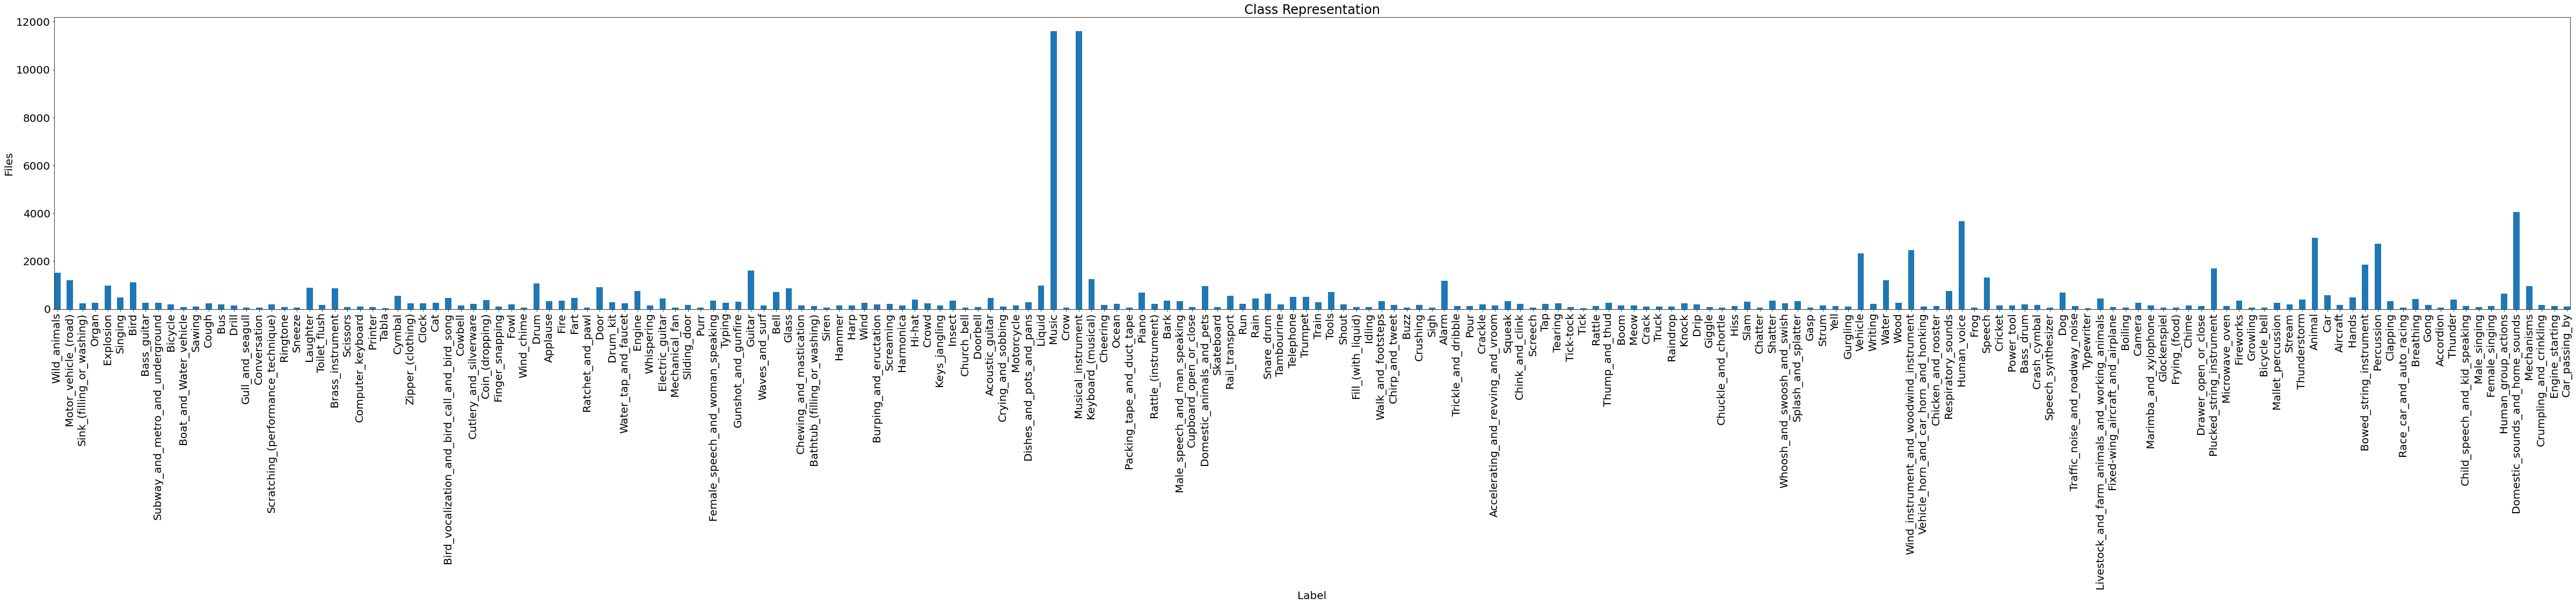

In [12]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize = (84, 10))
plt.bar([vocab_dict[i] for i in label_mids_classes], 
        np.sum(train_label_vector, axis=0),width=0.5)
plt.xlabel("Label")
plt.ylabel("Files")
plt.xticks(rotation='vertical')
plt.title("Class Representation")
plt.margins(x=0)
plt.show()

In [13]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

In [14]:
ytrain = train_label_vector

In [15]:
from scipy.io import wavfile
import glob
files = glob.glob("D:/Data/Chunks/*")
len(files)

597130

In [22]:
files[0].split("\\")[1].split("_")[0]

'100005'

In [26]:
X_train = []
X_train_files = []
i=0
for file in tqdm(files):
    y, sr = librosa.load(file)
    x = librosa.feature.mfcc(y=y, sr=sr).flatten()
    X_train_files.append(file.split("\\")[1].split("_")[0])
    X_train.append(x)
X_train = np.asarray(X_train)

100%|██████████| 597130/597130 [1:28:16<00:00, 112.74it/s]


In [30]:
df = pd.DataFrame(list(zip(X_train_files, X_train)), columns = ['File', 'MFCC'])

In [44]:
df.to_pickle("Traindata.pkl")

In [35]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [36]:
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	for train_ix, test_ix in cv.split(X):
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		model = get_model(n_inputs, n_outputs)
		model.fit(X_train, y_train, verbose=0, epochs=100)
		yhat = model.predict(X_test)
		yhat = yhat.round()
        
		acc = accuracy_score(y_test, yhat)
		print('>%.3f' % acc)
		results.append(acc)
	return results

In [37]:
test_files = glob.glob("D:/Data/Chunks_test/*")

In [38]:
len(test_files)

204720

In [41]:
X_test = []
X_test_files = []
for file in tqdm(test_files):
    y, sr = librosa.load(file)
    x = librosa.feature.mfcc(y=y, sr=sr).flatten()
    X_test_files.append(file.split("\\")[1].split("_")[0])
    X_test.append(x)
X_test = np.asarray(X_test)

100%|██████████| 204720/204720 [30:55<00:00, 110.31it/s]


In [42]:
df_test = pd.DataFrame(list(zip(X_test_files, X_test)), columns = ['File', 'MFCC'])

In [45]:
df_test.to_pickle("Testdata.pkl")

In [44]:
results = evaluate_model(X_train, y_train)
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

>1.000
>0.850
>0.950
>0.950
>0.800
>0.950
>0.900
>0.895
>1.000
>0.895
>0.950
>0.950
>0.950
>1.000
>0.850
>0.950
>0.900
>0.842
>0.895
>0.947
>0.800
>0.950
>0.900
>0.950
>0.900
>0.900
>0.950
>1.000
>0.947
>0.947
Accuracy: 0.922 (0.053)


In [16]:
object = pd.read_pickle(r'Traindata.pkl')

In [21]:
object.head(30)

,File,MFCC
0,100005,"[-274.68658, -248.46367, -239.70734, -204.2591..."
1,100006,"[-288.66394, -212.43222, -163.75542, -108.4241..."
2,100007,"[-537.1165, -429.98495, -294.9628, -205.4573, ..."
3,10000,"[-263.44003, -190.14992, -160.36128, -155.2517..."
4,100011,"[-360.68704, -329.4024, -326.6118, -305.60846,..."
5,100011,"[-300.81085, -251.53209, -217.5586, -202.98021..."
6,100011,"[7.9395914, -8.708869, -57.055794, -58.769897,..."
7,100011,"[-48.089077, -47.779793, -92.04151, -130.56293..."
8,100011,"[-181.8122, -173.71442, -197.29712, -205.00984..."
9,100011,"[-220.50151, -228.63036, -247.49422, -236.2922..."
